In [3]:
!pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.3 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 MB 11.3 MB/s eta 0:00:0000:0100:01
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 28.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.5 MB/s eta 0:00:00a 0:0

In [14]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Paths to the directories
norain_path = '/Users/sulagnasaha/Documents/rain-detection/fall_detection_audios/Mono_audios/norain'
rain_path = '/Users/sulagnasaha/Documents/rain-detection/fall_detection_audios/Mono_audios/rain'

# Function to extract MFCC features
def extract_features(audio, sr, max_len=130):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    if mfcc.shape[1] > max_len:
        mfcc = mfcc[:, :max_len]
    else:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    return mfcc

def augment_audio(audio, sr):
    # Add Gaussian noise
    noise = np.random.normal(0, 0.005, audio.shape)
    audio_with_noise = audio + noise

    # Pitch shift
    audio_pitch_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)

    # Time stretch
    audio_time_stretched = librosa.effects.time_stretch(audio, rate=1.2)

    return [audio_with_noise, audio_pitch_shifted, audio_time_stretched]


# Prepare dataset
X, y = [], []
for label, folder in enumerate([norain_path, rain_path]):
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            file_path = os.path.join(folder, file)
            audio, sr = librosa.load(file_path, sr=None)

            # Original features
            features = extract_features(audio, sr)
            X.append(features)
            y.append(label)

            # Augmented features
            for augmented_audio in augment_audio(audio, sr):
                augmented_features = extract_features(augmented_audio, sr)
                X.append(augmented_features)
                y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for CNN (add channel dimension)
X = X[..., np.newaxis]
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(40, 130, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5500 - loss: 28.6121 - val_accuracy: 0.2432 - val_loss: 8.9676
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5008 - loss: 14.0015 - val_accuracy: 0.7568 - val_loss: 1.6543
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7161 - loss: 4.4743 - val_accuracy: 0.2703 - val_loss: 1.5114
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.7183 - loss: 1.2084 - val_accuracy: 0.2703 - val_loss: 1.3008
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7639 - loss: 0.9224 - val_accuracy: 0.6216 - val_loss: 0.9563
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7377 - loss: 0.7542 - val_accuracy: 0.6757 - val_loss: 0.9490
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7645 - loss: 0.7049 - val_accuracy: 0.7027 - val_loss: 0.9397
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7669 - loss: 0.7226 - val_accuracy: 0.7027 - val_los

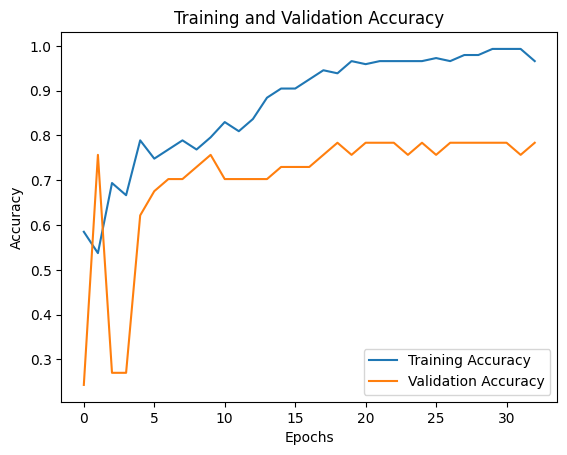

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,          # Stop if no improvement after 5 epochs
    restore_best_weights=True,  # Restore the best weights from the epoch with the lowest validation loss
    verbose=1
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping callback
)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


In [37]:
model.save('rain_detection_model.keras')

In [38]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7081 - loss: 0.6715
Test Accuracy: 70.27%
